In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   astropy.time import Time

import kaipy.kaiViz as kv
import kaipy.kaiH5 as kaiH5
import kaipy.transform as transform


import h5py
import datetime
import os
import json
import pandas as pd

Import the data into Pandas dataframes.  Note the handling of date time columns to create a temporal index for the data frames

In [2]:
swdir = '/glade/u/home/wiltbemj/Python/PowerGrid/HalloweenStormSW'

In [3]:
umdstdf = pd.read_csv(os.path.join(swdir,'Dst.txt'),skiprows=1, sep='\s+',
                      parse_dates={'date':['year','mo','dy','hr','mn','sc','msc']},
                      date_parser=lambda x: datetime.datetime.strptime(x,'%Y %m %d %H %M %S %f'),
                      index_col='date')

In [4]:
umdstdf

,dst_sm,AL
date,,
2003-10-29 00:35:00,-39.0,-569.0
2003-10-29 00:36:00,-40.0,-649.0
2003-10-29 00:37:00,-41.0,-649.0
2003-10-29 00:38:00,-42.0,-612.0
2003-10-29 00:39:00,-43.0,-549.0
...,...,...
2003-10-31 00:11:00,-322.0,-389.0
2003-10-31 00:12:00,-321.0,-367.0
2003-10-31 00:13:00,-313.0,-407.0


In [5]:
umswdf = pd.read_csv(os.path.join(swdir,'IMF.dat'),skiprows=[0,1,2,3,4,6], sep='\s+',
                      parse_dates={'date':['year','mo','dy','hr','mn','sc','msc']},
                      date_parser=lambda x: datetime.datetime.strptime(x,'%Y %m %d %H %M %S %f'),
                      index_col='date')

In [6]:
umswdf

,BX,BY,BZ,UX,UY,UZ,RHO,T
date,,,,,,,,
2003-10-29 00:35:33,3.59,5.65,-6.83,-597.09,-34.28,-38.89,5.16,488100.00
2003-10-29 00:35:49,5.10,3.96,-6.53,-597.06,-34.26,-38.83,5.16,489592.38
2003-10-29 00:36:06,6.09,2.93,-6.61,-597.03,-34.24,-38.75,5.16,491084.78
2003-10-29 00:36:22,5.72,4.15,-6.23,-597.00,-34.23,-38.68,5.16,492577.16
2003-10-29 00:36:38,5.23,4.93,-6.13,-596.97,-34.21,-38.61,5.16,494069.53
...,...,...,...,...,...,...,...,...
2003-10-31 00:15:56,-10.13,-26.52,5.23,-1216.25,-46.37,21.57,7.40,1122000.00
2003-10-31 00:16:12,-9.28,-25.47,4.04,-1215.74,-46.86,22.00,7.40,1122000.00
2003-10-31 00:16:29,-6.53,-24.43,4.15,-1215.24,-47.35,22.41,7.40,1122000.00


Merge the data frames into one with 1 min temporal resolution


In [7]:
rng = pd.date_range(datetime.datetime(2003,10,29,0,36,0),datetime.datetime(2003,10,31,0,16,0),freq='T')

In [8]:
tmpdf = pd.DataFrame(index=rng)

In [9]:
interpdf = pd.concat([umswdf,tmpdf,umdstdf]).sort_index().interpolate()

In [10]:
umergedf=interpdf.loc[~interpdf.index.duplicated(),:].reindex(rng)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

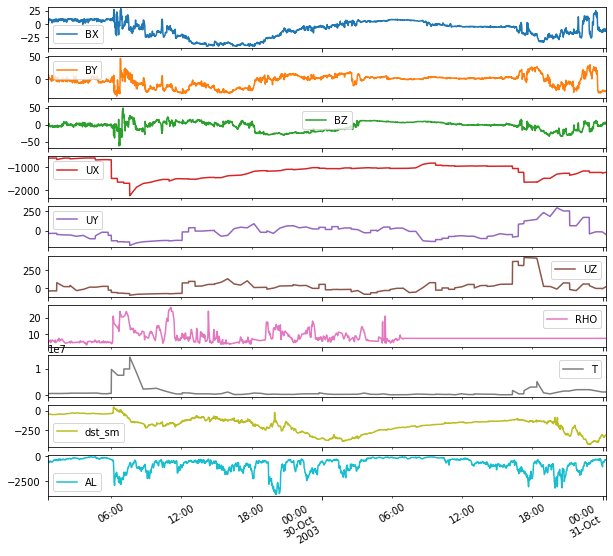

In [11]:
umergedf.plot(figsize=(10,10),subplots=True)

MAGE needs the magnetic field and velocity in SM coordinates.  Also need to add tilt angle, F10.7, elapsed seconds, and MJD to the data frame to support the creatation of the MAGE solar wind HDF file.

In [12]:
bx_sm = []
by_sm = []
bz_sm = []
for bx,by,bz, date in zip(umergedf['BX'].values,umergedf['BY'].values,umergedf['BZ'].values,umergedf.index):
    (x,y,z) = transform.GSMtoSM(bx,by,bz,date)
    bx_sm.append(x)
    by_sm.append(y)
    bz_sm.append(z)

In [13]:
vx_sm = []
vy_sm = []
vz_sm = []
for vx,vy,vz, date in zip(umergedf['UX'].values,umergedf['UY'].values,umergedf['UZ'].values,umergedf.index):
    (x,y,z) = transform.GSMtoSM(vx,vy,vz,date)
    vx_sm.append(x)
    vy_sm.append(y)
    vz_sm.append(z)

In [14]:
umergedf['UX_SM'] = vx_sm
umergedf['UY_SM'] = vy_sm
umergedf['UZ_SM'] = vz_sm
umergedf['BX_SM'] = bx_sm
umergedf['BY_SM'] = by_sm
umergedf['BZ_SM'] = bz_sm

In [15]:
tilt = []
for date in umergedf.index:
    (x,y,z) = transform.GSMtoSM(0,0,1,date)
    tilt.append(np.arctan2(x,z))
umergedf['tilt'] = tilt

In [16]:
umergedf['f107'] = 275.4
umergedf['f107'].loc['2003-10-30':'2003-10-31'] = 267.6
umergedf['f107'].loc['2003-10-31':'2003-11-01'] = 245.2

In [17]:
umergedf['elapsedsecs'] = np.arange(umergedf.shape[0])*60.

In [18]:
umergedf['MJD'] = Time(umergedf.index).mjd
    

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

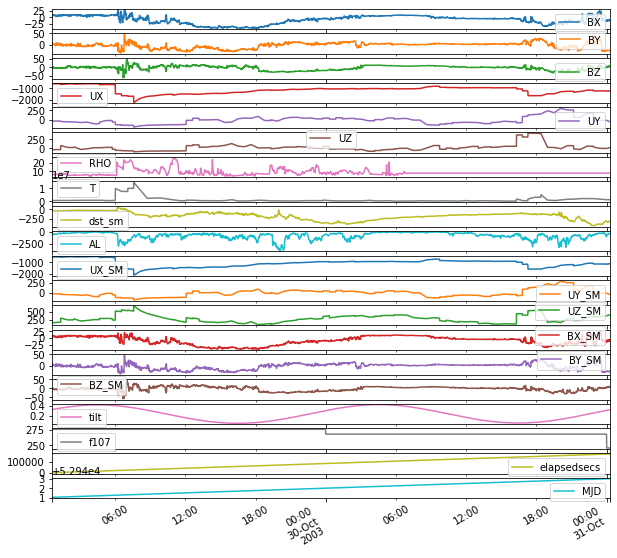

In [19]:
umergedf.plot(figsize=(10,10),subplots=True)

Create the MAGE solar wind file called umsw.h5

In [27]:
ut = []
for date in umergedf.index:
    ut.append(date.strftime('%Y-%m-%d %H:%M:%S'))


In [32]:
with h5py.File(os.path.join(swdir,'umsw.h5'),'w') as hf:
                hf.create_dataset("T" ,data=umergedf['elapsedsecs'].values)
                hf.create_dataset("UT",data=ut)
                hf.create_dataset("MJD",data=umergedf['MJD'].values)
                hf.create_dataset("D" ,data=umergedf['RHO'].values)
                hf.create_dataset("Temp" ,data=umergedf['T'].values)
                #For MAGE Velocity needs to be in m/s
                hf.create_dataset("Vx",data=umergedf['UX_SM'].values*1000)
                hf.create_dataset("Vy",data=umergedf['UY_SM'].values*1000)
                hf.create_dataset("Vz",data=umergedf['UZ_SM'].values*1000)
                hf.create_dataset("Bx",data=umergedf['BX_SM'].values)
                hf.create_dataset("By",data=umergedf['BY_SM'].values)
                hf.create_dataset("Bz",data=umergedf['BZ_SM'].values)
                hf.create_dataset("tilt",data=umergedf['tilt'].values)
                hf.create_dataset("al",data=umergedf['AL'].values)
                hf.create_dataset("symh",data=umergedf['dst_sm'].values)
                hf.create_dataset("f10.7",data=umergedf['f107'].values)
  